In [64]:
include("../src/cliff7.jl")
using PyPlot
using Profile

PyPlot.rc("font", family="serif")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"

"serif"

In [3]:
function cc_adam_gate!(state, b, i, j, p)
    ms = size(state, 1)==size(state, 2) ? fps_measurement! : measurement!
    cliff = random_clifford(2b)
    rg = union(b*i-b+1:b*i, b*j-b+1:b*j)
    clifford_action!(cliff, state, rg)
    if rand() < p
        obs = (0, Bool[1, 0])
        for k in b*i-b+1:b*i
            ms(state, obs, [k])
        end
    end
    if rand() < p
        obs = (0, Bool[1, 0])
        for k in b*j-b+1:b*j
            ms(state, obs, [k])
        end
    end
    return nothing
end

function cc_ee_sim(n, b, cut, p_list, n_step, step_size, burnin, n_average, periodic)
    result = zeros(length(p_list), n_step)
    for (k, p) in enumerate(p_list)
        for _ in 1:n_average
            state = all_up(n*b)
            for _ in 1:burnin
                for ini in [1, 2]
                    for i in ini : 2 : (periodic ? n : n-1)
                        j = i==n ? 1 : i+1
                        cc_adam_gate!(state, b, i, j, p)
                    end
                end
            end
            for t in 1:n_step
#                 result[k, t] += left_ee_on_all_cuts(state)[b*cut+1]
                for _ in 1:step_size
                    for ini in [1, 2]
                        for i in ini : 2 : (periodic ? n : n-1)
                            j = i==n ? 1 : i+1
                            cc_adam_gate!(state, b, i, j, p)
                        end
                    end
                end
            end
        end
    end
    result ./= n_average
    return result
end

cc_ee_sim (generic function with 1 method)

In [37]:
n = 128
b = 2
cut = div(n, 2)
p_list = [0.2]
n_step = 128
step_size = 1
burnin = 0
n_average = 100
periodic = true
nn = 30

30

In [38]:
Profile.clear()
Profile.init(Int(1e7), 0.01)
@profile cc_ee_sim(n, b, cut, p_list, n_step, step_size, burnin, n_average, periodic)

1×128 Array{Float64,2}:
 0.0  2.52  4.62  6.26  8.03  9.61  11.07  …  34.8  34.79  34.85  34.7  34.77

In [141]:
function rand_prod_state(n)
    xz = zeros(Bool, 2n, 2n)
    s = rand([0, 2], 2n)
    for i in 1:n
        a = rand()
        if a < 1/3
            xz[i, 2i-1] = true
            xz[i+n, 2i] = true
        elseif a < 2/3
            xz[i, 2i] = true
            xz[i+n, 2i-1] = true
        else
            xz[i, 2i-1] = true
            xz[i, 2i] = true
            xz[i+n, 2i] = true
            
            s[i] += 1
        end
    end
    return StabState(xz, s, n)
end
        

function cal_cc_ee(n, avg, ini_state, gate)
    ee = zeros(n+1)
    ee2 = zeros(n+1)
    for _ in 1:avg
        state = ini_state(n)
        cl = gate(n)
        clifford_action!(cl, state, 1:n)
        tmp = left_ee_on_all_cuts(state)
        ee += tmp
        ee2 += tmp.^2
    end
    Eee = ee ./ avg
    Eee2 = ee2 ./ avg
    Dee = sqrt.(Eee2 - Eee.^2)
    return Eee, Dee
end

function qec_ini_state(n, k, ancilla)
    xz = zeros(Bool, 2n+2k, 2n+2k)
    s = zeros(Int, 2n+2k)
    state_k = epr_pairs(k)
    if ancilla=="+"
        state_n = all_plus(n-k)
    elseif ancilla=="rand"
        state_n = rand_prod_state(n-k)
    else
        state_n = all_up(n-k)
    end
    xz = zeros(Bool, 2n+2k, 2n+2k)
    xz[1:2k, 1:4k] = state_k.xz[1:2k, :]
    xz[2k+1:k+n, 4k+1:2n+2k] = state_n.xz[1:n-k, :]
    xz[n+k+1:n+k+2k, 1:4k] = state_k.xz[2k+1:4k, :]
    xz[n+k+2k+1:2n+2k, 4k+1:2n+2k] = state_n.xz[n-k+1:2n-2k, :]
    s = zeros(Int, 2n+2k)
    s[1:2k] = state_k.s[1:2k]
    s[2k+1:n+k] = state_n.s[1:n-k]
    s[n+k+1:n+k+2k] = state_k.s[2k+1:4k]
    s[n+k+2k+1:2n+2k] = state_n.s[n-k+1:2n-2k]
    return StabState(xz, s, n+k)
end
    
    
function QEC_sim(n, k, t, state, gate)
    # [k-ref | n-physical]
    cl = gate(n)
    clifford_action!(cl, state, k+1:k+n)
    mi = mutual_info(state, 1:k, k+t+1:k+n)
    mn = mutual_neg(state, 1:k, k+t+1:k+n)
    return mi-2mn, mn
end


function QEC_run(n_list, k_list, ini_list, t_list, avg, gate)
    result = zeros(length(n_list), length(k_list), length(ini_list), length(t_list))
    for (i1, n) in enumerate(n_list), (i2, k) in enumerate(k_list), (i3, ini) in enumerate(ini_list)
        state = qec_ini_state(n, k, ini)
        for (i4, t) in enumerate(t_list), _ in 1:avg
            nc, nq = QEC_sim(n, k, t, state, gate)
            result[i1, i2, i3, i4] += k - nq
        end
    end
    return result ./ avg
end
    

QEC_run (generic function with 1 method)

In [159]:
avg = 10000
n_list = 2:2:48
k_list = [1]
t_list = [1]
ini_list = ["0", "+", "rand"]
gate = random_cc_clifford

result1 = QEC_run(n_list, k_list, ini_list, t_list, avg, gate);

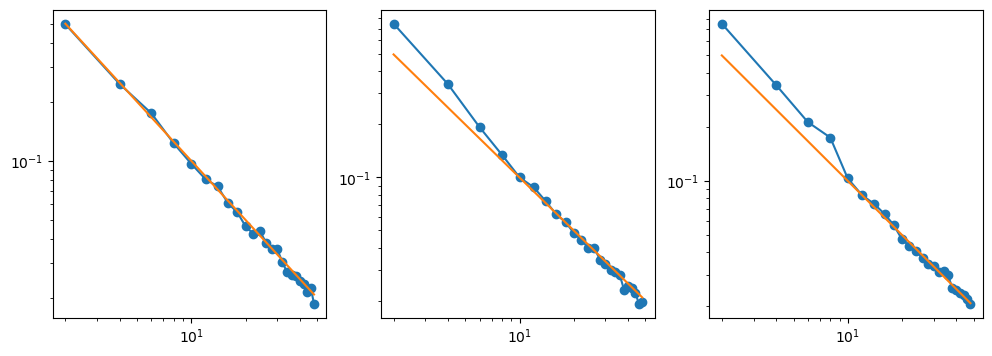

In [160]:
result = result1

fg, ax = subplots(1, 3, figsize=(12, 4))

for i in 1:3
    x = n_list
    y = result[:, 1, i, 1]
    ax[i].plot(x, y, "-o")
    ax[i].plot(x, x.^(-1))
    
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")
end




In [161]:
avg = 10000
n_list = [48]
k_list = [1]
t_list = 1:12
ini_list = ["0", "+", "rand"]
gate = random_cc_clifford

result2 = QEC_run(n_list, k_list, ini_list, t_list, avg, gate);

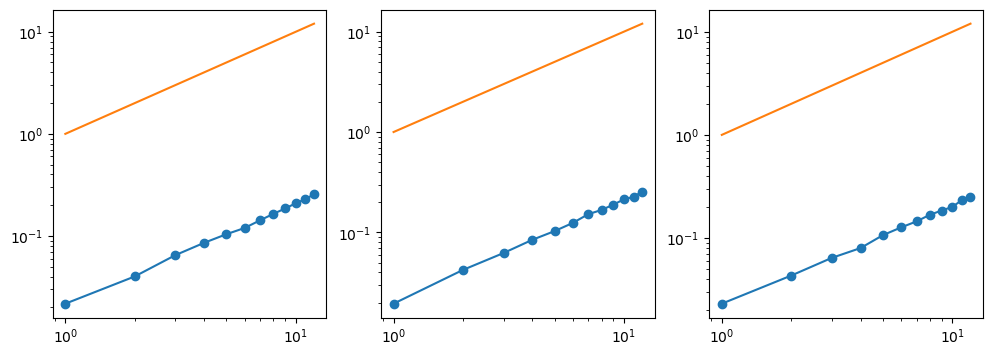

In [163]:
result = result2

fg, ax = subplots(1, 3, figsize=(12, 4))


for i in 1:3
    x = t_list
    y = result[1, 1, i, :]
    ax[i].plot(x, y, "-o")
    ax[i].plot(x, x.^(1))
    
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")
end


In [164]:
avg = 10000
n_list = [48]
k_list = 1:12
t_list = [1]
ini_list = ["0", "+", "rand"]
gate = random_cc_clifford

result3= QEC_run(n_list, k_list, ini_list, t_list, avg, gate);

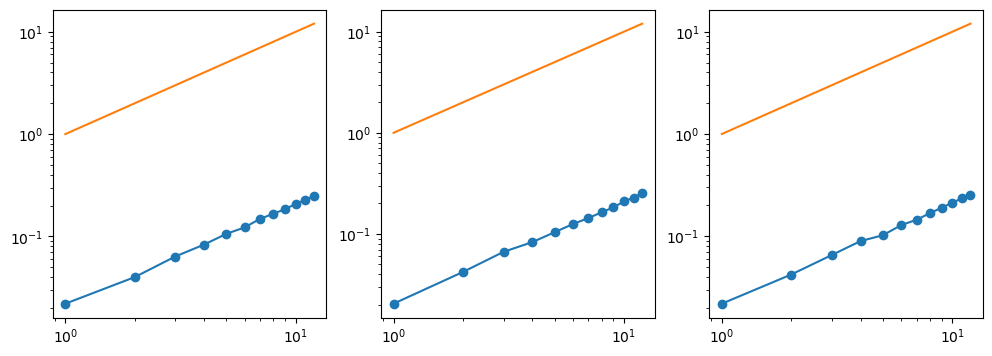

In [167]:
result = result3

fg, ax = subplots(1, 3, figsize=(12, 4))


for i in 1:3
    x = k_list
    y = result[1, :, i, 1]
    ax[i].plot(x, y, "-o")
    ax[i].plot(x, x.^(1))
    
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")
end


In [193]:
avg = 10000
n_list = [32]
k_list = 2:2:12
t_list = 2:2:12
ini_list = ["0", "+", "rand"]
gate = random_cc_clifford

result4= QEC_run(n_list, k_list, ini_list, t_list, avg, gate);

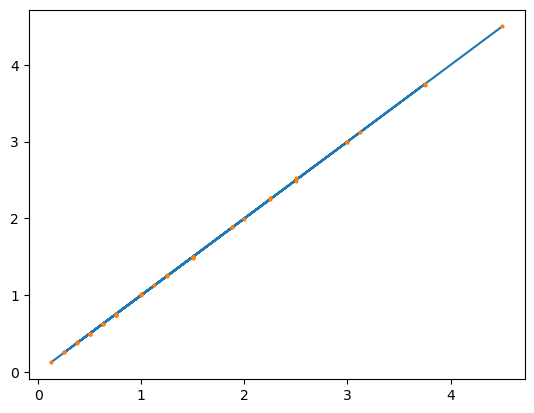

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000007F8A640>

In [194]:
result = result4

fg, ax = subplots(1)

n = 32
x = Float64[]
y = Float64[]
for a in 1:3
    for (i, k) in enumerate(k_list)
        for (j, t) in enumerate(t_list)
    #         push!(x, 1 - binomial(n-k, t) / binomial(n, t) )
            push!(x, t*k/n )
            push!(y, result[1, i, 1, j] )
        end
    end
    ax.plot(x,x)
    ax.plot(x, y, "o", ms=2)
end

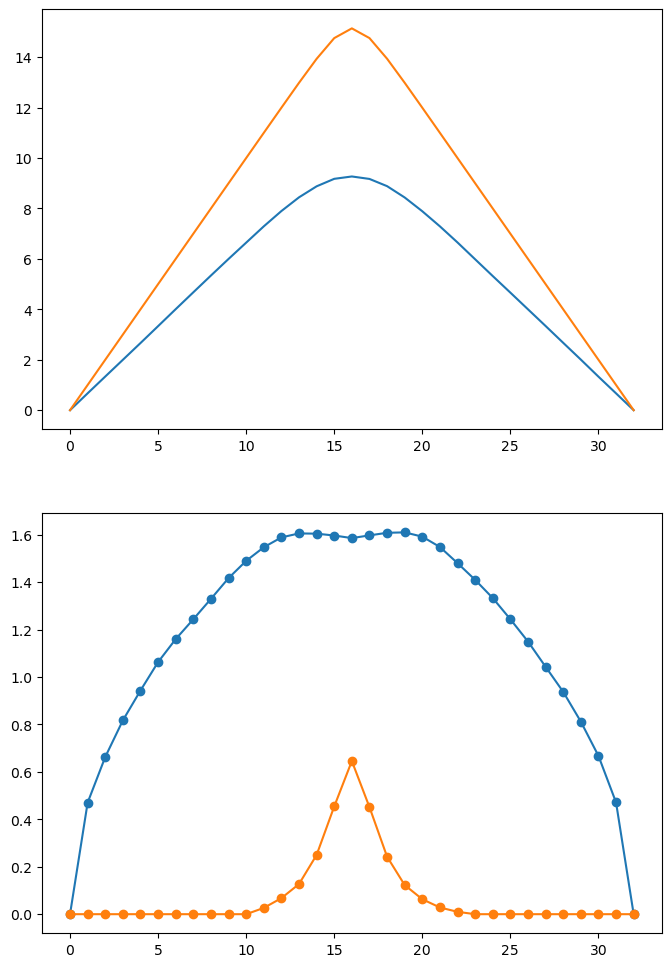

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000621C1A00>

In [111]:

fg, ax = subplots(2, figsize=(8, 12))

ax[1].plot(Eee1)
ax[1].plot(Eee2)

ax[2].plot(Dee1, "-o")
ax[2].plot(Dee2, "-o")
# ax[2].set_yscale("log")

In [112]:
n = 32
k = 1
ancilla = "+"
n_loss = 1
gate = random_cc_clifford

state = qec_ini_state(n, k, ancilla)
result = [QEC_sim(n, k, n_loss, copy(state), gate)]

(0, 2)

In [1]:
function purified_d(n, k, t, a)
    alpha = Int(a * n)
    myb = binomial
    H(i, j) = 2. ^(-k) * myb(n - t, j - i + alpha) / myb(n, j + alpha)
    A(c, l) = sum([myb(l, m1) * myb(k-l, m2) * sqrt(H(c + m1, m1 + m2) / 2^k) for m1 in 0:l, m2 in 0:k-l])
    Pl(l) = myb(t, l) * myb(n - t, k - l) / myb(n, k)
    Pc(c, l) = myb(t - l, c) * myb(n - t - k + l, alpha - c) / myb(n - k, alpha)
    result = 0.
    for l in 0:min(t, k)
        for c in 0:min(t-l, alpha)
            result += Pl(l) * Pc(c, l) * sqrt(1 - A(c, l)^2)
        end
    end
    return result
end

purified_d (generic function with 1 method)

In [148]:
function op_evolve(ops, n_step)
    n = div(length(ops[1]), 2)
    result = zeros(Bool, length(ops), 2n_step, 2n)
    for i in 1:length(ops)
        result[i, 1, :] = ops[i]
    end

    for t in 2:2n_step
        ini = isodd(t) + 1
        for i in ini:2:n-1
            bmat = binary_charge_conserving_symplectic_mat(2)
            indices = 2i-1:2i+2
            for j in 1:length(ops)
                result[j, t, indices] = isodd.(bmat' * result[j, t-1, indices] )
            end
        end
    end
    return result
end

op_evolve (generic function with 1 method)

In [174]:
n = 32
n_step = 48

op1 = zeros(Bool, 4n+2)
op1[2n+1] = true

op2 = zeros(Bool, 4n+2)
op2[2n+2] = true

op3 = zeros(Bool, 4n+2)
op3[2n+1-div(n,2)] = op3[2n+1+div(n,2)] = true

op4 = zeros(Bool, 4n+2)
op4[2n+2-div(n,2)] = op4[2n+2+div(n,2)] = true

ops = [op1, op2, op3, op4]
result = op_evolve(ops, n_step);

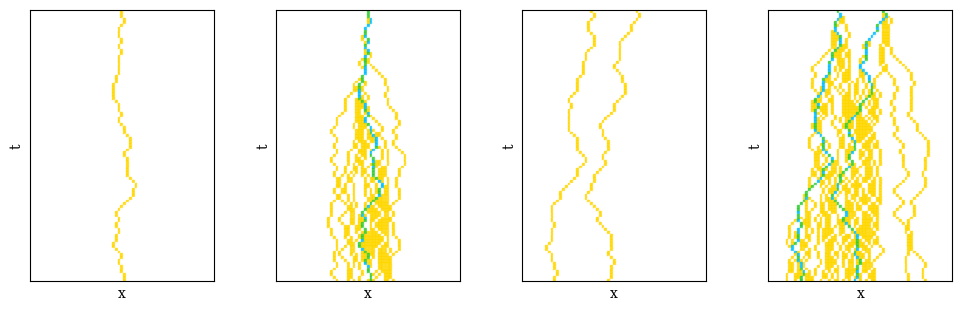

In [175]:
using PyCall
using LaTeXStrings

@pyimport matplotlib.patches as patches
begin
    fg, axs = subplots(1, size(result, 1), figsize=(10, 20))
    fg.tight_layout()
    
    for l in 1:size(result, 1)

        ax = axs[l]

        bmat_x = result[l, :, 1:2:end]'
        bmat_z = result[l, :, 2:2:end]'


        cs = ["w", "limegreen", "gold", "deepskyblue"]
        ts = [L"I", L"X", L"Z", L"Y"]
        m, n = size(bmat_x)
        a = 5
        b = 4.5


        ax.imshow(zeros(a*n, a*m))
        x, y = 1.7,2.5

        ax.add_patch(patches.Rectangle((-1,-1), a*m+1, a*n+1, color="w"))
        for i in 1:m
            for j in 1:n
                color = cs[2bmat_x[i, j]+bmat_z[i, j]+1]
    #             t = ts[2bmat_x[i, j]+bmat_z[i, j]+1]
                ax.add_patch(patches.Rectangle(((i-1)*a,(j-1)*a), b, b, color=color, alpha=0.8))
    #             ax.text((i-1)*a+x, (j-1)*a+y, t,fontsize=10)
            end
        end
        
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    end

    
    fg.savefig("data_opspread.pdf", bbox_inches="tight")
end

In [138]:
result[1, :, :]

10×22 Array{Bool,2}:
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0